In [38]:
import numpy as np
import matplotlib.pyplot as plt
import random

import pdb

In [39]:
class Random2DGaussian:
    """
    Random bivariate normal distribution sampler

    Hardwired parameters:
      d0min,d0max: horizontal range for the mean
      d1min,d1max: vertical range for the mean
      scalecov: controls the covariance range 

    Methods:
      __init__: creates a new distribution

      get_sample(n): samples n datapoints

    """
    d0min=0 
    d0max=10
    d1min=0 
    d1max=10
    scalecov=5
  
    def __init__(self):
        dw0,dw1 = self.d0max-self.d0min, self.d1max-self.d1min
        mean = (self.d0min,self.d1min)
        mean += np.random.random_sample(2)*(dw0, dw1)
        eigvals = np.random.random_sample(2)
        eigvals *= (dw0/self.scalecov, dw1/self.scalecov)
        eigvals **= 2
        theta = np.random.random_sample()*np.pi*2
        R = [[np.cos(theta), -np.sin(theta)], 
             [np.sin(theta), np.cos(theta)]]
        Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
        self.get_sample = lambda n: np.random.multivariate_normal(mean,Sigma,n)

In [40]:
def graph_surface(function, rect, offset=0.5, width=256, height=256):
    """
    Creates a surface plot (visualize with plt.show)

    Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

    Returns:
    None
    """

    lsw = np.linspace(rect[0][1], rect[1][1], width) 
    lsh = np.linspace(rect[0][0], rect[1][0], height)
    xx0,xx1 = np.meshgrid(lsh, lsw)
    grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)

    #get the values and reshape them
    values=function(grid).reshape((width,height))

    # fix the range and offset
    delta = offset if offset else 0
    maxval=max(np.max(values)-delta, - (np.min(values)-delta))

    # draw the surface and the offset
    plt.pcolormesh(xx0, xx1, values, 
    vmin=delta-maxval, vmax=delta+maxval)

    if offset != None:
        plt.contour(xx0, xx1, values, colors='black', levels=[offset])

In [41]:
def graph_data(X,Y_, Y, special=[]):
    """Creates a scatter plot (visualize with plt.show)

    Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

    Returns:
      None
    """
    # colors of the datapoint markers
    palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
    colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
    for i in range(len(palette)):
        colors[Y_==i] = palette[i]

    # sizes of the datapoint markers
    sizes = np.repeat(20, len(Y_))
    sizes[special] = 40

    # draw the correctly classified datapoints
    good = (Y_==Y)
    plt.scatter(X[good,0],X[good,1], c=colors[good], 
              s=sizes[good], marker='o')

    # draw the incorrectly classified datapoints
    bad = (Y_!=Y)
    plt.scatter(X[bad,0],X[bad,1], c=colors[bad], 
              s=sizes[bad], marker='s')

In [42]:
def class_to_onehot(Y):
    Yoh=np.zeros((len(Y),max(Y)+1))
    Yoh[range(len(Y)),Y] = 1
    return Yoh

In [43]:
def eval_perf_binary(Y, Y_):
    tp = sum(np.logical_and(Y==Y_, Y_==True))
    fn = sum(np.logical_and(Y!=Y_, Y_==True))
    tn = sum(np.logical_and(Y==Y_, Y_==False))
    fp = sum(np.logical_and(Y!=Y_, Y_==False))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp+fn + tn+fp)
    return accuracy, recall, precision

In [44]:
def eval_perf_multi(Y, Y_):
    pr = []
    n = max(Y_)+1
    M = np.bincount(n * Y_ + Y, minlength=n*n).reshape(n, n)
    for i in range(n):
        tp_i = M[i,i]
        fn_i = np.sum(M[i,:]) - tp_i
        fp_i = np.sum(M[:,i]) - tp_i
        tn_i = np.sum(M) - fp_i - fn_i - tp_i
        recall_i = tp_i / (tp_i + fn_i)
        precision_i = tp_i / (tp_i + fp_i)
        pr.append( (recall_i, precision_i) )

    accuracy = np.trace(M)/np.sum(M)

    return accuracy, pr, M

In [45]:
def eval_AP(ranked_labels):
    """Recovers AP from ranked labels"""

    n = len(ranked_labels)
    pos = sum(ranked_labels)
    neg = n - pos

    tp = pos
    tn = 0
    fn = 0
    fp = neg
  
    sumprec=0
    #IPython.embed()
    for x in ranked_labels:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)    

    if x:
        sumprec += precision
      
    #print (x, tp,tn,fp,fn, precision, recall, sumprec)
    #IPython.embed()

    tp -= x
    fn += x
    fp -= not x
    tn += not x

    return sumprec/pos

In [46]:
def sample_gauss(nclasses, nsamples):
    # create the distributions and groundtruth labels
    Gs=[]
    Ys=[]
    for i in range(nclasses):
        Gs.append(Random2DGaussian())
        Ys.append(i)

    # sample the dataset
    X = np.vstack([G.get_sample(nsamples) for G in Gs])
    Y_= np.hstack([[Y]*100 for Y in Ys])

    return X,Y_

In [47]:
def sample_gmm(ncomponents, nclasses, nsamples):
    # create the distributions and groundtruth labels
    Gs=[]
    Ys=[]
    for i in range(ncomponents):
        Gs.append(Random2DGaussian())
        Ys.append(np.random.randint(nclasses))

    # sample the dataset
    X = np.vstack([G.get_sample(nsamples) for G in Gs])
    Y_= np.hstack([[Y]*nsamples for Y in Ys])

    return X,Y_

In [48]:
def myDummyDecision(X):
    scores = X[:,0] + X[:,1] - 5
    return scores

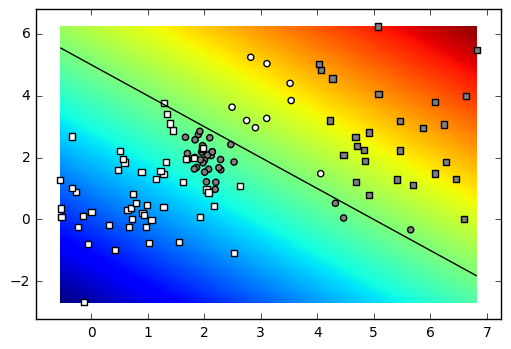

In [49]:
np.random.seed(100)

# get data
X,Y_ = sample_gmm(4, 2, 30)
# X,Y_ = sample_gauss(2, 100)

# get the class predictions
Y = myDummyDecision(X)>0.5  

# graph the decision surface
rect=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(myDummyDecision, rect, offset=0)

# graph the data points
graph_data(X, Y_, Y, special=[])

plt.show()

In [61]:
def binlogreg_train(X, Y_):
    '''
       Argumenti
        X:  podatci, np.array NxD
        Y_: indeksi razreda, np.array Nx1

       Povratne vrijednosti
        w, b: parametri logističke regresije
    '''
    
    N = X.shape[0]
    w = np.random.rand(X.shape[1], 1)
    b = np.zeros(shape=[N, 1])

    # gradijentni spust (param_niter iteracija)
    param_niter=10000
    param_delta=0.005

    for i in range(param_niter):
        # klasifikacijski rezultati
        scores = np.dot(X, w) + b    # N x 1

        # vjerojatnosti razreda c_1
        probs = sigm(scores)    # N x 1

        # gubitak
        # scalar
        loss = -1 * float(np.dot(Y_.T, np.log(probs)))     

        # derivacije gubitka po klasifikacijskom rezultatu
        dL_dscores = probs - Y_.reshape(len(Y_),1)     # N x 1

        # gradijenti parametara
        grad_w = np.divide(np.dot(X.T, dL_dscores), N)  # D x 1
        grad_b = np.divide(np.sum(dL_dscores), N)  # 1 x 1
        
        # poboljšani parametri
        w += -param_delta * grad_w.reshape(grad_w.shape[0], 1)
        b += -param_delta * grad_b

        # dijagnostički ispis
        if i % 10 == 0:
            print("iteration {}: loss {}".format(i, loss))

    return w,b

def sigm(x):
    return 1 / (1 + np.exp(-x))

def binlogreg_classify(X, w, b):
    '''
        Argumenti
            X:    podatci, np.array NxD
            w, b: parametri logističke regresije 

        Povratne vrijednosti
            probs: vjerojatnosti razreda c1
    '''
    
    print(X.shape)
    print(w.shape)
    print(b.shape)
    scores = np.dot(X, w) + b
    probs = sigm(scores)
    
    classes = probs.copy()
    classes[np.where(probs < 0.5)] = 0
    classes[np.where(probs >= 0.5)] = 1
    
    return classes

In [62]:
def binlogreg_decfun(X,w,b):
    def classify(X):
        return binlogreg_classify(X,w,b)
    return classify

In [63]:
np.random.seed(100)

# get the training dataset
X,Y_ = sample_gauss(2, 100)

print(X.shape)

# train the model
w,b = binlogreg_train(X, Y_)

# evaluate the model on the training dataset
probs = binlogreg_classify(X,w,b)

"""
accuracy, recall, precision = eval_perf_binary(probs, Y_)
AP = eval_AP(Y_[probs.argsort()])
print (accuracy, recall, precision, AP)
"""

decfun = binlogreg_decfun(X,w,b)
bbox=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(decfun, bbox, offset=0.5)

# graph the data points
graph_data(X, Y_, Y, special=[])

# show the plot
plt.show()

(200, 2)
iteration 0: loss 5.041248812342523
iteration 10: loss 8.085272584958673
iteration 20: loss 12.427667267561665
iteration 30: loss 17.75363141410478
iteration 40: loss 23.06719132128302
iteration 50: loss 27.271749845147216
iteration 60: loss 29.90175730711796
iteration 70: loss 31.130066171182605
iteration 80: loss 31.369395161203272
iteration 90: loss 31.00227619905612
iteration 100: loss 30.30245600580659
iteration 110: loss 29.44389937345153
iteration 120: loss 28.529863947762273
iteration 130: loss 27.618510597648534
iteration 140: loss 26.740719839483212
iteration 150: loss 25.91138840490736
iteration 160: loss 25.136284877863332
iteration 170: loss 24.41611549855501
iteration 180: loss 23.748901230770816
iteration 190: loss 23.131350686487142
iteration 200: loss 22.559641248019226
iteration 210: loss 22.02985321978936
iteration 220: loss 21.53820154982191
iteration 230: loss 21.081150307960996
iteration 240: loss 20.65546011186621
iteration 250: loss 20.258198050338073
i

iteration 6540: loss 8.389242316084248
iteration 6550: loss 8.387851764370742
iteration 6560: loss 8.386464844817795
iteration 6570: loss 8.385081542576868
iteration 6580: loss 8.383701842882571
iteration 6590: loss 8.382325731051875
iteration 6600: loss 8.380953192483652
iteration 6610: loss 8.379584212658045
iteration 6620: loss 8.378218777135912
iteration 6630: loss 8.376856871558239
iteration 6640: loss 8.375498481645606
iteration 6650: loss 8.374143593197566
iteration 6660: loss 8.372792192092163
iteration 6670: loss 8.371444264285344
iteration 6680: loss 8.370099795810397
iteration 6690: loss 8.368758772777447
iteration 6700: loss 8.36742118137286
iteration 6710: loss 8.36608700785878
iteration 6720: loss 8.364756238572568
iteration 6730: loss 8.363428859926278
iteration 6740: loss 8.362104858406173
iteration 6750: loss 8.360784220572102
iteration 6760: loss 8.359466933057146
iteration 6770: loss 8.358152982566981
iteration 6780: loss 8.356842355879435
iteration 6790: loss 8.3555

ValueError: operands could not be broadcast together with shapes (65536,1) (200,1) 